In [1]:
cd ..

/home/wesg/research/neuron-stats


In [2]:
# autoreload
%load_ext autoreload
%autoreload 2

import os
import pickle
import einops
import torch
import numpy as np
import pandas as pd
from transformer_lens import HookedTransformer
import matplotlib.pyplot as plt
import seaborn as sns
import datasets
import torch
import itertools
from utils import *

torch.set_grad_enabled(False)

%matplotlib inline

/usr/lib/python3/dist-packages/requests/__init__.py:87: RequestsDependencyWarning: urllib3 (2.0.6) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [5]:
model_name = 'stanford-gpt2-medium-a'

neuron_df = pd.read_csv(f'dataframes/neuron_dfs/{model_name}.csv')

neuron_df = pd.read_csv(f'dataframes/neuron_dfs/{model_name}.csv')
vocab_df = pd.read_csv('dataframes/vocab_dfs/gpt2.csv')
vocab_df.loc[vocab_df.token_string.isna(), 'token_string'] = 'n/a'

In [7]:
neuron_df['excess_correlation'] = neuron_df['mean_corr'] - neuron_df['mean_baseline']

In [14]:
neuron_df.query('kurt < 2 and excess_correlation > 0.5')

2    5
1    3
5    1
Name: layer, dtype: int64

In [15]:
dataset_name = 'pile.test.all-10m.512'
ds = datasets.load_from_disk(os.path.join('token_datasets', 'gpt2', dataset_name))

token_mapping = vocab_df.token_string.to_dict()

In [16]:
tokens = ds['tokens']
subset = ds['subset']
n, d = tokens.shape

sequence_subset = einops.repeat(np.array(subset), 'n -> n d', d=d)
sequence_ix = einops.repeat(np.arange(n), 'n -> n d', d=d)
position = einops.repeat(np.arange(d), 'd -> n d', n=n)


dataset_df = pd.DataFrame({
    'token': tokens.flatten().numpy(),
    'token_str': [token_mapping[t] for t in tokens.flatten().numpy()],
    'subset': sequence_subset.flatten(),
    'sequence_ix': sequence_ix.flatten(),
    'position': position.flatten(),
})

In [17]:
def pos_mutual_info(activations):
    _, d = activations.shape
    fire_rate = (activations > 0).float().mean()
    pos_fire_rate = (activations > 0).float().mean(axis=0)

    log_fr = np.log(pos_fire_rate / fire_rate + 1e-9)
    log_inv_fr = np.log((1 - pos_fire_rate) / (1 - fire_rate) + 1e-9)

    pos_mi = pos_fire_rate * log_fr + (1 - pos_fire_rate) * log_inv_fr
    return (pos_mi.sum() / d).item()


In [19]:
n_seq, n_ctx = ds['tokens'].shape
pos_dict = {}
for ix, (l, n) in enumerate(neuron_df.query('kurt < 2 and excess_correlation > 0.5')[['layer', 'neuron']].values):
    if ix % 100 == 0:
        print(ix, l, n)
    activations = torch.load(f'cached_activations/stanford-gpt2-medium-a/pile.test.all-10m.512/{l}.{n}.pt')
    activations = activations.reshape(n_seq, n_ctx)
    binary_mi = pos_mutual_info(activations)

    pos_std = activations.mean(axis=0).std().item()
    pos_std_mean = activations.std(axis=0).mean().item()
    pos_dict[(l, n)] = {
        'binary_mi': binary_mi,
        'pos_std': pos_std,
        'pos_std_mean': pos_std_mean,
    }

0 1 838


In [20]:
subg_pos_df = pd.DataFrame(pos_dict).T.sort_values('binary_mi')
subg_pos_df.index.names = ['layer', 'neuron']

In [21]:
subg_pos_df

binary_mi   pos_std  pos_std_mean
layer neuron                                   
5     386      0.090993  0.814941      0.262939
2     3126     0.177736  1.024414      0.180054
1     3075     0.231565  0.956543      0.145386
2     3550     0.305903  0.937500      0.189575
      3171     0.347370  1.251953      0.175293
      583      0.368435  1.120117      0.163818
1     838      0.484212  1.076172      0.147827
      3816     0.487319  1.237305      0.191162
2     217      0.537455  1.141602      0.156006

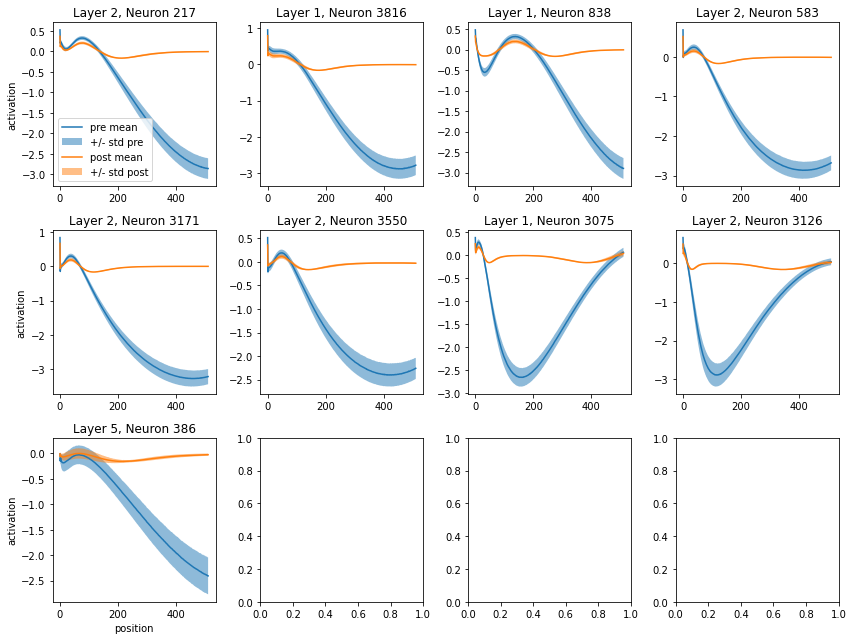

In [22]:
import math
neurons = subg_pos_df.sort_values('binary_mi', ascending=False).reset_index().head(20)[['layer', 'neuron']].values

n_cols = 4
n_rows = math.ceil(len(neurons) / n_cols)

fig, axs = plt.subplots(n_rows, n_cols, figsize=(3 * n_cols, 3 * n_rows))

for ix, (l, n) in enumerate(neurons):
    ax = axs[ix // n_cols, ix % n_cols]
    activations = torch.load(f'cached_activations/stanford-gpt2-medium-a/pile.test.all-10m.512/{l}.{n}.pt')
    pre_activations = activations.reshape(n_seq, n_ctx).float()
    post_activations = torch.nn.GELU()(pre_activations)
    pre_act_mean = pre_activations.mean(axis=0).numpy()
    pre_act_std = pre_activations.std(axis=0).numpy()
    post_act_mean = post_activations.mean(axis=0).numpy()
    post_act_std = post_activations.std(axis=0).numpy()


    # shade mean with shaded area for std
    # ax.plot(act_mean)
    # ax.fill_between(np.arange(len(act_mean)), act_mean - act_std, act_mean + act_std, alpha=0.5)
    ax.plot(pre_act_mean, label='pre activation')
    ax.fill_between(np.arange(len(pre_act_mean)), pre_act_mean - pre_act_std, pre_act_mean + pre_act_std, alpha=0.5)
    ax.plot(post_act_mean, label='post activation')
    ax.fill_between(np.arange(len(post_act_mean)), post_act_mean - post_act_std, post_act_mean + post_act_std, alpha=0.5)

    ax.set_title(f'Layer {l}, Neuron {n}')

    # left plots add y axis
    if ix % n_cols == 0:
        ax.set_ylabel('activation')

    if ix // n_cols == n_rows - 1:
        ax.set_xlabel('position')
    
    if ix == 0:
        ax.legend(['pre mean', '+/- std pre', 'post mean', '+/- std post'])


plt.tight_layout()
